In [1]:
!pip install fuzzywuzzy s3fs

import os, glob, json
import pandas as pd
import numpy as np
from datetime import datetime
from IPython.display import clear_output 
from fuzzywuzzy import fuzz
from s3fs import S3FileSystem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Step 1: Scope the Project and Gather Data

In [2]:
data_dir = "drive/MyDrive/udacity_capstone"

First we load all match data and convert the `match_date` column to a datetime type so we can filter by date.

In [3]:
matches_files_dir = "statsbomb-football-data/matches/11/"

json_pattern = os.path.join(f"{data_dir}/{matches_files_dir}",'*.json')
file_list = glob.glob(json_pattern)

matches = []

for file in file_list:

    with open(file) as f:
      d = json.load(f)
      data = pd.json_normalize(d)
      matches.append(data)

matches_df = pd.concat(matches, ignore_index=True)

In [4]:
matches_df["match_date"] = pd.to_datetime(matches_df["match_date"] + " " + matches_df["kick_off"])
matches_df = matches_df[matches_df["match_date"] >= '2014-08-01']

The matches data looks pretty complete. Only the Referee data seems missing about 20% and the manager data is only there in 95%.

We then import the events data. This process takes the longest (~ 3 minutes for 1 million datapoints) since every matche's events are saved in a seperate JSON. Here also on of the biggest challenges arises. The data is saved very unnormalized. We can still import it to pandas and normalize it but this leads to very sparse data. We normalize it again as dimensions.

In [7]:
event_file_list = matches_df.match_id.tolist()

events_files_dir = "statsbomb-football-data/events"

events = []
count = 0
for event_file in event_file_list:
    with open(f"{data_dir}/{events_files_dir}/{event_file}.json") as f:
      d = json.load(f)
      data = pd.json_normalize(d)
      data['match_id'] = event_file
      data['match_date'] = matches_df.loc[matches_df["match_id"] == event_file, 'match_date'].item()
      events.append(data)
    count += 1
    clear_output()
    print(f"{count}/{len(event_file_list)} files done")

all_events = pd.concat(events, ignore_index=True)


243/243 files done


We then import the player data including their FIFA stats. SInce we are only looking at La Liga games of FC Barcelona we can already filter out all player of Spain Primera Division.

In [9]:
players_files_dir = "fifa"

json_pattern = os.path.join(f"{data_dir}/{players_files_dir}",'*.csv')
player_file_list = glob.glob(json_pattern)

all_players = pd.read_csv(f"{data_dir}/{players_files_dir}/players_22.csv")
all_players = all_players[all_players["league_name"] == "Spain Primera Division"]

for player_file in player_file_list:
  player_ids = all_players["sofifa_id"].to_list()
  new_players = pd.read_csv(player_file)
  new_players = new_players[new_players["league_name"] == "Spain Primera Division"]
  new_players = new_players[~new_players["sofifa_id"].isin(player_ids)]
  all_players = all_players.append(new_players, ignore_index = True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (25,108) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (104) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (81,82,83,84,85) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Step 2: Explore and Asses Data

We have to map event data to Fifa data based on the players name. We therefore check how many players don't have a matching name in both datasets

In [11]:
player_names = all_events[all_events["player.name"].notnull()]["player.name"].unique().tolist()
event_players = all_players[all_players["long_name"].isin(player_names)]

In [12]:
unknown_players = [x for x in player_names if x not in event_players["long_name"].to_list()]
print(f"Unknown Player: {len(unknown_players)}")

Unknown Player: 172


There is a chance that one dataset might is missing an additional name or has a different way of writing a name. We therefore use the library `fuzzywuzzy` which gives a ratio how similar two strings are.

In [13]:
fuzzy_player_matching = [max([[fuzz.token_set_ratio(j,i),i, j] for i in all_players["long_name"].to_list()]) for j in unknown_players]
fuzzy_player_matching = pd.DataFrame(fuzzy_player_matching, columns=["score", "correct_name", "incomplete_name"])
fuzzy_player_matching

,score,correct_name,incomplete_name
0,100,Steven N'Kemboanza Mike Christopher Nzonzi,Steven N''Kemboanza Mike Christopher Nzonzi
1,98,Sergio Roberto Carnicer,Sergi Roberto Carnicer
2,100,Luciano Darío Vietto,Luciano Vietto
3,98,Neymar da Silva Santos Júnior,Neymar da Silva Santos Junior
4,100,Vicente Iborra de la Fuente,Vicente Iborra De La Fuente
...,...,...,...
167,56,Armando Sadiku,Saidy Janko
168,100,Juan Cruz Álvaro Armada,Álvaro Juan Cruz Armada
169,98,Edgar Badia Guardiola,Edgar Badía Guardiola
170,70,Emiliano Buendía,Emiliano Ariel Rigoni


We see that names with a score higher than 80 seems to be the same. We therefore add them to the `event_player` DataFrame.

In [14]:
guessed_unknown_players = fuzzy_player_matching[fuzzy_player_matching["score"] > 85]["correct_name"].to_list()
event_players = event_players.append(all_players[all_players["long_name"].isin(guessed_unknown_players)])

We are still missing the names of around 1,3% of all events. We plot those names to see their distribution.

In [15]:
print(f"Still unknown players: {len(unknown_players) - len(guessed_unknown_players)}")
unknown_players = fuzzy_player_matching[fuzzy_player_matching["score"]<= 85]["incomplete_name"].to_list()
print(f"Percentage of events of unknown player: {len(all_events[all_events['player.name'].isin(unknown_players)])/len(all_events)}")

Still unknown players: 61
Percentage of events of unknown player: 0.013021169207487467


We can clearly see that most events are from Sergino Dest, who is a known FC Barcelona player. By looking at the fuzzy matching we see that his score of 72 didn't made the cut. So we add him manually. By looking up some of the other players we see that the problem is, that they have been on a loan to La Liga during winter break and therefore are not recognized as La Liga players by Fifa. Since those players only answer for 0,8% of the events we accept it as waste.

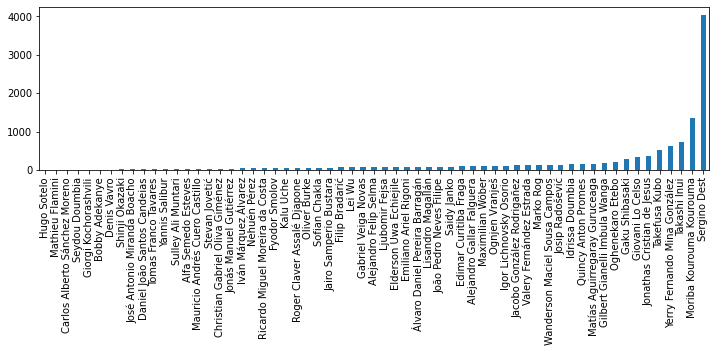

In [16]:
all_events[all_events['player.name'].isin(unknown_players)]["player.name"] \
  .value_counts().sort_values().plot(kind="bar", figsize=(12,3))

In [17]:
event_players = event_players.append(all_players[all_players["long_name"] == "Sergiño Gianni Dest"])
fuzzy_player_matching.loc[fuzzy_player_matching.index[fuzzy_player_matching['correct_name'] == "Sergiño Gianni Dest"], "score"] = 100

We change the correct name for all events to be consistent over both datasets.

In [18]:
for index, row in fuzzy_player_matching[fuzzy_player_matching["score"] > 85].iterrows():
  all_events["player.name"] = all_events["player.name"].replace(row["incomplete_name"], row["correct_name"])

The same we did for players we also do for the team names and we have no waste here but FC Barcelona is guessed incorrectly we therefore need to change it manually as well.

In [19]:
matches_df = matches_df.replace("Barcelona", "FC Barcelona")
incomplete_teamnames = matches_df["home_team.home_team_name"].unique()
correct_teamnames = all_players["club_name"].unique()

In [20]:
fuzzy_team_matching = [max([(fuzz.token_set_ratio(j,i),i, j) for i in correct_teamnames.tolist()]) for j in incomplete_teamnames.tolist()]

In [21]:
fuzzy_team_matching

[(100, 'Sevilla FC', 'Sevilla'),
 (100, 'CA Osasuna', 'Osasuna'),
 (100, 'Real Madrid CF', 'Real Madrid'),
 (100, 'CD Leganés', 'Leganés'),
 (100, 'FC Barcelona', 'FC Barcelona'),
 (100, 'Athletic Club de Bilbao', 'Athletic Club'),
 (100, 'Real Betis Balompié', 'Real Betis'),
 (100, 'Unión Deportiva Las Palmas', 'Las Palmas'),
 (100, 'Villarreal CF', 'Villarreal'),
 (100, 'Valencia CF', 'Valencia'),
 (90, 'Deportivo de La Coruña', 'Deportivo La Coruna'),
 (100, 'Deportivo Alavés', 'Deportivo Alavés'),
 (100, 'SD Eibar', 'Eibar'),
 (100, 'Málaga CF', 'Málaga'),
 (100, 'RCD Espanyol de Barcelona', 'Espanyol'),
 (100, 'Atlético de Madrid', 'Atlético Madrid'),
 (100, 'Real Sociedad', 'Real Sociedad'),
 (100, 'Getafe CF', 'Getafe'),
 (100, 'Córdoba CF', 'Córdoba'),
 (100, 'Rayo Vallecano', 'Rayo Vallecano'),
 (100, 'Elche CF', 'Elche'),
 (100, 'Granada CF', 'Granada'),
 (100, 'Unión Deportiva Almería', 'Almería'),
 (100, 'RC Celta de Vigo', 'Celta Vigo'),
 (100, 'Levante Unión Deportiva', '

In [22]:
for team in fuzzy_team_matching:
  matches_df = matches_df.replace(team[2], team[1])

To get rid of the sparse table we want to save the attribute values in a seperate facts table. We therefore go through all attributes and save them in a new DataFrame. We also need to rename some of the attribute names for better matching the columns.

In [23]:
all_events["type.name"] = all_events["type.name"] \
  .replace("Goal Keeper", "Goalkeeper") \
  .replace("Ball Receipt*", "Ball Receipt") \
  .replace("50/50", "50_50")

In [24]:
events_df = all_events
attributes = []

for type_name in events_df["type.name"].unique():
  type_columns = [col for col in events_df.columns if type_name.lower().replace(" ", "_") in col]

  if len(type_columns)>0:
    for attribute in type_columns:
      if attribute.endswith(".id") or attribute.endswith(".freeze_frame"):
        events_df.drop(attribute, axis=1, inplace=True)
        continue
      data = events_df[events_df[attribute].notna()][["id", "match_date", attribute]]
      data["value"] = data[attribute]
      data = data.drop(attribute, axis=1)
      data["name"] = attribute
      events_df.drop(attribute, axis=1, inplace=True)
      attributes.append(data)

attributes_df = pd.concat(attributes, ignore_index=True)

In [25]:
attributes_df.head()

,id,match_date,value,name
0,3ae35b11-2f48-4f9b-b92a-efa43aeae36b,2015-01-04 21:00:00,True,half_start.late_video_start
1,fffce76b-0aee-4fff-9e64-b16b83050e40,2015-01-04 21:00:00,True,half_start.late_video_start
2,bc608e09-1dab-431f-a285-9f6c484e575e,2018-05-06 20:45:00,True,half_start.late_video_start
3,aee27872-47ff-421c-8592-d51e7de27078,2018-05-06 20:45:00,True,half_start.late_video_start
4,9ace527b-d86a-40ce-b106-3c31a3b74e0a,2019-04-02 21:30:00,True,half_start.late_video_start


### Partitioning

The further processing is happening in Airflow. We therefore save the preprocessed data as csv to a S3 bucket. The events and attributes data is partioned by match_date to minimize data skewness.

NOTE: The file type csv was chosen because compatibility problems were experienced in between paquet and redshift.

In [26]:
BUCKET_NAME = "capstone-football"
FILE_SUFFIX = f"{matches_df['match_date'].min().strftime('%Y%m%d')}-{matches_df['match_date'].max().strftime('%Y%m%d')}"

In [27]:
ACCESS_KEY = ""
SECRET = ""

In [28]:
s3 = S3FileSystem(key=ACCESS_KEY, secret=SECRET)

In [29]:
FOLDER_NAME = "attribute_events"

columns = [ "name", "id", "value" ]

for i, x in attributes_df.groupby(["match_date"]):
  with s3.open(f"{BUCKET_NAME}/{FOLDER_NAME}/{FOLDER_NAME}_{i}.csv",'w') as f:
        x[columns].to_csv(f, index=False)

In [30]:
columns = [
      "match_id",
      "match_date",
      "home_score",
      "away_score",
      "competition.competition_id",
      "season.season_id",
      "home_team.home_team_id",
      "home_team.home_team_name",
      "away_team.away_team_id",
      "away_team.away_team_name" ]

FOLDER_NAME = "matches"

with s3.open(f"{BUCKET_NAME}/{FOLDER_NAME}/{FOLDER_NAME}_{FILE_SUFFIX}.csv",'w') as f:
      matches_df[columns].set_index("match_id").to_csv(f)

In [31]:
columns = [
  "id",
  "period",
  "minute",
  "second",
  "possession",
  "type.id",
  "type.name",
  "match_id",
  "possession_team.id",
  "play_pattern.name",
  "team.id",
  "player.name",
  "location",
  "duration",
  "out",
]

FOLDER_NAME = "events"

for i, x in events_df.groupby(["match_date"]):
   with s3.open(f"{BUCKET_NAME}/{FOLDER_NAME}/{FOLDER_NAME}_{i}.csv",'w') as f:
      x[columns].set_index("id").to_csv(f)

In [32]:
player_stats = [
  "shooting",
  "power_strength",
  "power_stamina",
  "power_shot_power",
  "power_long_shots",
  "power_jumping",
  "physic",
  "passing",
  "pace",
  "movement_sprint_speed",
  "movement_reactions",
  "movement_balance",
  "movement_agility",
  "movement_acceleration",
  "mentality_vision",
  "mentality_positioning",
  "mentality_penalties",
  "mentality_interceptions",
  "mentality_composure",
  "mentality_aggression",
  "goalkeeping_speed",
  "goalkeeping_reflexes",
  "goalkeeping_positioning",
  "goalkeeping_kicking",
  "goalkeeping_handling",
  "goalkeeping_diving",
  "dribbling",
  "defending_standing_tackle",
  "defending_sliding_tackle",
  "defending_marking_awareness",
  "defending",
  "attacking_volleys",
  "attacking_short_passing",
  "attacking_heading_accuracy",
  "attacking_finishing",
  "attacking_crossing",
]

event_players[player_stats] = np.array(event_players[player_stats], np.int16)

In [33]:
columns = [
  "sofifa_id",
  "long_name",
  "nationality_name",
  "dob",
  "player_positions",
  "overall",
  "potential",
  "value_eur",
  "wage_eur",
  "work_rate",
  "weight_kg",
  "height_cm",
  "weak_foot",
  "skill_moves",
  "preferred_foot",
]
columns = [*columns, *player_stats]

FOLDER_NAME = "players"
TABLE_NAME = "LaLiga14-22"

with s3.open(f"{BUCKET_NAME}/{FOLDER_NAME}/{TABLE_NAME}.csv",'w') as f:
      event_players[columns].set_index("sofifa_id").to_csv(f)